In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F

In [2]:
class MakeClass(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        uniques = torch.unique(x, sorted = True)
        if uniques.shape[0] > 3:
            x[x == 0] = uniques[2]
            uniques = torch.unique(x, sorted = True)
        for i, v in enumerate(uniques):
            x[x == v] = i
        
        x = x.to(dtype=torch.long)
        onehot = F.one_hot(x.squeeze(1), 3).permute(0, 3, 1, 2)[0].float()
        return onehot

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.PILToTensor(), 
        MakeClass()
    ]
)

train_ds = OxfordIIITPet(
    root = "/media/mountHDD2/data", split = "trainval", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

test_ds = OxfordIIITPet(
    root = "/media/mountHDD2/data", split = "test", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

#Training Samples: 3680
#Testing Samples: 3669
#Training Batch: 58
#Testing Batch: 58


In [4]:
sample_data, sample_mask = train_ds[100]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")

print(f"Number classes: {np.unique(sample_mask.numpy())}")

data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([3, 256, 256])
Number classes: [0. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


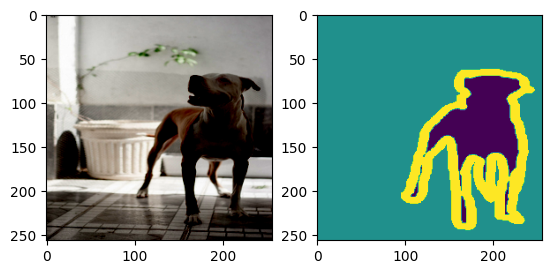

In [5]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(sample_data.cpu().permute(1, -1, 0).numpy())
axarr[1].imshow(sample_mask.argmax(0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [8]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
class VanillaSegV0(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.act = nn.Softmax(dim=1)

    def forward(self, pred, target) -> torch.Tensor:

        pred_soft = self.act(pred)

        logits = torch.log(pred_soft)

        B, C, H, W = tuple(logits.size())

        entropy = logits * target

        return (-1 / (B * H * W)) * torch.sum(entropy)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, 3, False).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

# loss_fn = nn.CrossEntropyLoss()
loss_fn = VanillaSegV0()

In [13]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device, dtype = torch.long)

        train_gen_mask = model(train_img)
        train_loss = loss_fn(train_gen_mask, train_mask.squeeze(1))

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(test_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device, dtype = torch.long)

            valid_gen_img = model(valid_img)
            valid_loss = loss_fn(valid_gen_img, valid_mask.squeeze(1))

            va_total_loss += valid_loss.item()

    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")

model.load_state_dict(best_dct)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.48it/s]


Epoch: 0 - TrainLoss: 0.7557959145513075 - ValidLoss: 1.0075174631743595


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.37it/s]


Epoch: 1 - TrainLoss: 0.5503426178775984 - ValidLoss: 0.5325779729876025


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.37it/s]


Epoch: 2 - TrainLoss: 0.47667377724729737 - ValidLoss: 0.4845117027389592


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.50it/s]


Epoch: 3 - TrainLoss: 0.4243566810057081 - ValidLoss: 0.47865789512108115


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.28it/s]


Epoch: 4 - TrainLoss: 0.3942785972151263 - ValidLoss: 0.4282655047959295


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.26it/s]


Epoch: 5 - TrainLoss: 0.37481372366691457 - ValidLoss: 0.4072793593694424


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.56it/s]


Epoch: 6 - TrainLoss: 0.35085407464668666 - ValidLoss: 0.35953811838709077


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.44it/s]


Epoch: 7 - TrainLoss: 0.33511685348790266 - ValidLoss: 0.3788143016141036


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.44it/s]


Epoch: 8 - TrainLoss: 0.3249680035073182 - ValidLoss: 0.35971174414815577


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.36it/s]


Epoch: 9 - TrainLoss: 0.314508994077814 - ValidLoss: 0.33052387114228876


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.21it/s]


Epoch: 10 - TrainLoss: 0.29416120823087366 - ValidLoss: 0.30446309878908356


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.45it/s]


Epoch: 11 - TrainLoss: 0.286463566895189 - ValidLoss: 0.3202690579767885


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.45it/s]


Epoch: 12 - TrainLoss: 0.2775401645179453 - ValidLoss: 0.31000939319873677


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.29it/s]


Epoch: 13 - TrainLoss: 0.2714423231523612 - ValidLoss: 0.2982237595936348


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.24it/s]


Epoch: 14 - TrainLoss: 0.26040547752174836 - ValidLoss: 0.32109235381257945


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.46it/s]


Epoch: 15 - TrainLoss: 0.25234895944595337 - ValidLoss: 0.3052243785611514


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.19it/s]


Epoch: 16 - TrainLoss: 0.23963051417778278 - ValidLoss: 0.3136669137868388


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.42it/s]


Epoch: 17 - TrainLoss: 0.23909857329623452 - ValidLoss: 0.29245154302695703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.36it/s]


Epoch: 18 - TrainLoss: 0.22105697953495487 - ValidLoss: 0.3008247220824505


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.25it/s]


Epoch: 19 - TrainLoss: 0.2153987776616524 - ValidLoss: 0.3047109426095568


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.42it/s]


Epoch: 20 - TrainLoss: 0.20442856822548242 - ValidLoss: 0.30631722792469224


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.33it/s]


Epoch: 21 - TrainLoss: 0.19442129135131836 - ValidLoss: 0.29600443973623475


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.51it/s]


Epoch: 22 - TrainLoss: 0.19299457170839968 - ValidLoss: 0.3087322835264535


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.20it/s]


Epoch: 23 - TrainLoss: 0.19748177199528136 - ValidLoss: 0.30145849415968207


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.34it/s]


Epoch: 24 - TrainLoss: 0.1841464677247508 - ValidLoss: 0.3090065085682376


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.26it/s]


Epoch: 25 - TrainLoss: 0.1813581847938998 - ValidLoss: 0.29332918802212027


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.34it/s]


Epoch: 26 - TrainLoss: 0.17265384515811658 - ValidLoss: 0.32414676505943824


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.46it/s]


Epoch: 27 - TrainLoss: 0.16922523029919329 - ValidLoss: 0.2936924947746869


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.29it/s]


Epoch: 28 - TrainLoss: 0.15785847886882978 - ValidLoss: 0.3368672016879608


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.37it/s]


Epoch: 29 - TrainLoss: 0.15606011553057308 - ValidLoss: 0.30592109956618013


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.28it/s]


Epoch: 30 - TrainLoss: 0.14703544357727313 - ValidLoss: 0.30543572918094436


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.41it/s]


Epoch: 31 - TrainLoss: 0.14605469153872852 - ValidLoss: 0.305157246517724


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.23it/s]


Epoch: 32 - TrainLoss: 0.14258036120184536 - ValidLoss: 0.339404157009618


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.32it/s]


Epoch: 33 - TrainLoss: 0.14026335883757163 - ValidLoss: 0.3125629124456438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.28it/s]


Epoch: 34 - TrainLoss: 0.13434421104089966 - ValidLoss: 0.3231676750141999


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.48it/s]


Epoch: 35 - TrainLoss: 0.1330501333135983 - ValidLoss: 0.321330106207009


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.22it/s]


Epoch: 36 - TrainLoss: 0.12648224226873497 - ValidLoss: 0.3207064294095697


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.39it/s]


Epoch: 37 - TrainLoss: 0.12210743822928133 - ValidLoss: 0.34103742986917496


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.21it/s]


Epoch: 38 - TrainLoss: 0.11851911452309839 - ValidLoss: 0.3375635347489653


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.26it/s]


Epoch: 39 - TrainLoss: 0.1180592540266185 - ValidLoss: 0.35451259798017043


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.30it/s]


Epoch: 40 - TrainLoss: 0.11530006214462478 - ValidLoss: 0.34994831809709814


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.22it/s]


Epoch: 41 - TrainLoss: 0.11135507657610137 - ValidLoss: 0.34147706062629307


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.28it/s]


Epoch: 42 - TrainLoss: 0.10698475765770879 - ValidLoss: 0.35808953077628697


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.25it/s]


Epoch: 43 - TrainLoss: 0.1063819801242187 - ValidLoss: 0.3672648061966074


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.27it/s]


Epoch: 44 - TrainLoss: 0.12111725671024158 - ValidLoss: 0.3479885911119395


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.46it/s]


Epoch: 45 - TrainLoss: 0.1137150433556787 - ValidLoss: 0.3565247726851496


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.27it/s]


Epoch: 46 - TrainLoss: 0.10176002786591135 - ValidLoss: 0.3518875950369342


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.30it/s]


Epoch: 47 - TrainLoss: 0.09762358537008023 - ValidLoss: 0.35929764807224274


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.38it/s]


Epoch: 48 - TrainLoss: 0.09376447994647355 - ValidLoss: 0.38805759980760773


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.42it/s]


Epoch: 49 - TrainLoss: 0.09128923238865261 - ValidLoss: 0.39032285532047006


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.20it/s]


Epoch: 50 - TrainLoss: 0.0891998646588161 - ValidLoss: 0.3813391384379617


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.32it/s]


Epoch: 51 - TrainLoss: 0.08766234897334 - ValidLoss: 0.39486493529944583


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.31it/s]


Epoch: 52 - TrainLoss: 0.08491976893153684 - ValidLoss: 0.399612997112603


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.47it/s]


Epoch: 53 - TrainLoss: 0.08309859731074037 - ValidLoss: 0.4029606878757477


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.25it/s]


Epoch: 54 - TrainLoss: 0.0811515480023006 - ValidLoss: 0.4177915998573961


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.44it/s]


Epoch: 55 - TrainLoss: 0.07926019782136226 - ValidLoss: 0.4194868890375927


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.16it/s]


Epoch: 56 - TrainLoss: 0.07744784768799255 - ValidLoss: 0.42722269738542623


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.25it/s]


Epoch: 57 - TrainLoss: 0.07565209539286022 - ValidLoss: 0.43066851023969976


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.28it/s]


Epoch: 58 - TrainLoss: 0.07385718372875247 - ValidLoss: 0.42742182417162533


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.40it/s]


Epoch: 59 - TrainLoss: 0.0726396763889954 - ValidLoss: 0.4345897872900141


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.53it/s]


Epoch: 60 - TrainLoss: 0.07097304175639975 - ValidLoss: 0.43356974474314985


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.39it/s]


Epoch: 61 - TrainLoss: 0.0701112022687649 - ValidLoss: 0.4575738819508717


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.36it/s]


Epoch: 62 - TrainLoss: 0.06754522134774718 - ValidLoss: 0.46244016598010884


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.19it/s]


Epoch: 63 - TrainLoss: 0.06561682193443694 - ValidLoss: 0.4583026412232169


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.51it/s]


Epoch: 64 - TrainLoss: 0.06416690889103659 - ValidLoss: 0.465160487540837


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.19it/s]


Epoch: 65 - TrainLoss: 0.0629082977257926 - ValidLoss: 0.475819678142153


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.40it/s]


Epoch: 66 - TrainLoss: 0.06219988894359819 - ValidLoss: 0.4776285557911314


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.40it/s]


Epoch: 67 - TrainLoss: 0.061221666634082794 - ValidLoss: 0.47507495921233606


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.24it/s]


Epoch: 68 - TrainLoss: 0.060077673851929865 - ValidLoss: 0.48503816436076985


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.33it/s]


Epoch: 69 - TrainLoss: 0.05850835606969636 - ValidLoss: 0.49072349174269314


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.21it/s]


Epoch: 70 - TrainLoss: 0.05790412162655387 - ValidLoss: 0.5015933729451278


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.30it/s]


Epoch: 71 - TrainLoss: 0.05670787015094839 - ValidLoss: 0.49442649195934163


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.24it/s]


Epoch: 72 - TrainLoss: 0.055949531945175136 - ValidLoss: 0.504193127155304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.31it/s]


Epoch: 73 - TrainLoss: 0.054933380849402524 - ValidLoss: 0.502541024623246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.16it/s]


Epoch: 74 - TrainLoss: 0.054121041606212485 - ValidLoss: 0.5112461267874159


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.42it/s]


Epoch: 75 - TrainLoss: 0.05302375310967709 - ValidLoss: 0.5191111903766106


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.36it/s]


Epoch: 76 - TrainLoss: 0.052470261423752225 - ValidLoss: 0.5164750244083076


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.30it/s]


Epoch: 77 - TrainLoss: 0.051877698700489666 - ValidLoss: 0.5240073132103887


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.39it/s]


Epoch: 78 - TrainLoss: 0.05094551063817123 - ValidLoss: 0.5282863419631432


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.27it/s]


Epoch: 79 - TrainLoss: 0.05025796566543908 - ValidLoss: 0.5283287856085547


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.43it/s]


Epoch: 80 - TrainLoss: 0.04995410285633186 - ValidLoss: 0.5327600990903789


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.25it/s]


Epoch: 81 - TrainLoss: 0.04943239695296205 - ValidLoss: 0.5341651532156714


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.36it/s]


Epoch: 82 - TrainLoss: 0.04912985296084963 - ValidLoss: 0.5382322453219315


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.48it/s]


Epoch: 83 - TrainLoss: 0.04883499809637152 - ValidLoss: 0.5389802471317094


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.32it/s]


Epoch: 84 - TrainLoss: 0.04852972995361377 - ValidLoss: 0.5392177927082983


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.26it/s]


Epoch: 85 - TrainLoss: 0.048148116867603924 - ValidLoss: 0.5410252105573128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.18it/s]


Epoch: 86 - TrainLoss: 0.04751360853170526 - ValidLoss: 0.5473656407718


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.39it/s]


Epoch: 87 - TrainLoss: 0.04715749704889182 - ValidLoss: 0.5478639931514345


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.34it/s]


Epoch: 88 - TrainLoss: 0.047333848502101566 - ValidLoss: 0.5496977963324251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.46it/s]


Epoch: 89 - TrainLoss: 0.04719073344664327 - ValidLoss: 0.5488039979646946


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.38it/s]


Epoch: 90 - TrainLoss: 0.04724493931079733 - ValidLoss: 0.5528497274579673


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.27it/s]


Epoch: 91 - TrainLoss: 0.04631533672840431 - ValidLoss: 0.5549154862247664


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.25it/s]


Epoch: 92 - TrainLoss: 0.04626809246838093 - ValidLoss: 0.5491877516795849


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.32it/s]


Epoch: 93 - TrainLoss: 0.046325783405838344 - ValidLoss: 0.5529185918898418


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.30it/s]


Epoch: 94 - TrainLoss: 0.046145362201435815 - ValidLoss: 0.5540852541553563


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.26it/s]


Epoch: 95 - TrainLoss: 0.04595010188119165 - ValidLoss: 0.5540861919008452


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.33it/s]


Epoch: 96 - TrainLoss: 0.04613431568803458 - ValidLoss: 0.5545602851900561


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.33it/s]


Epoch: 97 - TrainLoss: 0.04606221918145131 - ValidLoss: 0.5519466759829685


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.40it/s]


Epoch: 98 - TrainLoss: 0.045946815725544404 - ValidLoss: 0.5515609830617905


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.34it/s]

Epoch: 99 - TrainLoss: 0.045632699889869524 - ValidLoss: 0.5525659476888591


<All keys matched successfully>

  0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 20%|███████████████████████████████████                                                                                                                                            | 2/10 [00:00<00:00, 16.13it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the v

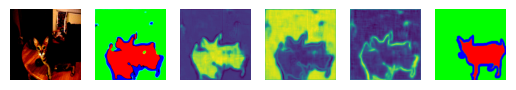

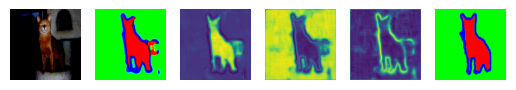

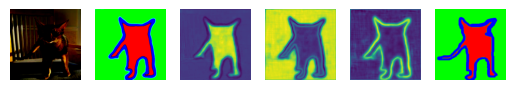

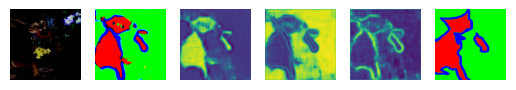

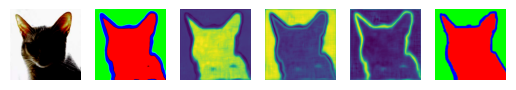

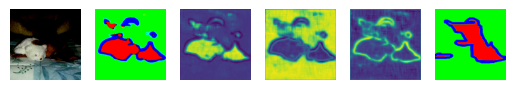

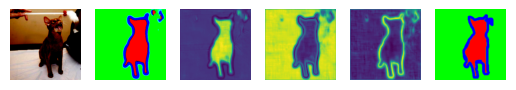

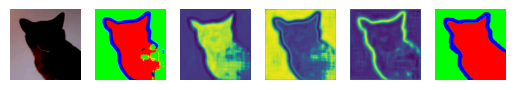

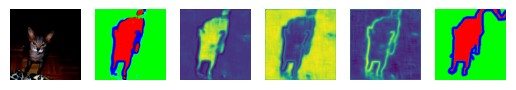

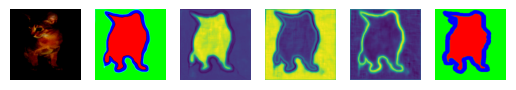

In [14]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     

        f, axarr = plt.subplots(1, 6)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(gen_mask[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(gen_mask[0][0].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        axarr[3].imshow(gen_mask[0][1].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[3].axis('off')
        axarr[4].imshow(gen_mask[0][2].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[4].axis('off')
        axarr[5].imshow(valid_mask.cpu().permute(1, -1, 0).numpy())
        axarr[5].axis('off')